## One week energy demand forecast of the Netherlands

In this project we want to predict the energy demand of the Netherlands for one week. First we will try a simple LSTM using the following data:
- historical energy demand data
- historical and future weather data
- special event data (e.g. public holidays)

## Historical electricity demand data



### Data collection
For the historical electricity demand data we can use publicly available data from entso-e.eu that collects and publishes electricity generation and consumption data. To start we can download energy demand data from https://data.open-power-system-data.org/time_series/ (15 min frequency) as SQL databases.

To run this notebook, download the database and save it in the data/raw folder

Let's load the electricity demand data

In [30]:
import sqlite3

connection = sqlite3.connect('../data/raw/time_series.sqlite')

cursor = connection.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables found in database:")
for t in tables:
    print("-", t[0])

# connection.close()

Tables found in database:
- time_series_15min_singleindex
- time_series_30min_singleindex
- time_series_60min_singleindex


In [25]:
connection = sqlite3.connect('../data/raw/time_series.sqlite')
cursor = connection.cursor()
table_name = "time_series_15min_singleindex"

cursor.execute(f"PRAGMA table_info({table_name});")
columns_info = cursor.fetchall()

print("Columns in table:")
for col in columns_info:
    print("-", col[1])

connection.close()

Columns in table:
- utc_timestamp
- cet_cest_timestamp
- AT_load_actual_entsoe_transparency
- AT_load_forecast_entsoe_transparency
- AT_price_day_ahead
- AT_solar_generation_actual
- AT_wind_onshore_generation_actual
- BE_load_actual_entsoe_transparency
- BE_load_forecast_entsoe_transparency
- DE_load_actual_entsoe_transparency
- DE_load_forecast_entsoe_transparency
- DE_solar_capacity
- DE_solar_generation_actual
- DE_solar_profile
- DE_wind_capacity
- DE_wind_generation_actual
- DE_wind_profile
- DE_wind_offshore_capacity
- DE_wind_offshore_generation_actual
- DE_wind_offshore_profile
- DE_wind_onshore_capacity
- DE_wind_onshore_generation_actual
- DE_wind_onshore_profile
- DE_50hertz_load_actual_entsoe_transparency
- DE_50hertz_load_forecast_entsoe_transparency
- DE_50hertz_solar_generation_actual
- DE_50hertz_wind_generation_actual
- DE_50hertz_wind_offshore_generation_actual
- DE_50hertz_wind_onshore_generation_actual
- DE_LU_load_actual_entsoe_transparency
- DE_LU_load_forecast_e

We can find the actual load of the Netherlands in the column **NL_load_actual_entsoe_transparency** and the timestamp in **utc_timestamp**. So now we can load the dataframe:


In [33]:
import pandas as pd

connection = sqlite3.connect('../data/raw/time_series.sqlite')

table_name = 'time_series_15min_singleindex'
column_names = ['utc_timestamp', 'NL_load_actual_entsoe_transparency']

df = pd.read_sql(f"SELECT {', '.join(column_names)} FROM {table_name}", connection)

df.head()

print('Length of dataset is:', len(df))

Length of dataset is: 201604


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201604 entries, 0 to 201603
Data columns (total 2 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   utc_timestamp                       201604 non-null  object 
 1   NL_load_actual_entsoe_transparency  201598 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB


In [35]:
df.describe()

,NL_load_actual_entsoe_transparency
count,201598.000000
mean,12578.456013
std,2290.400411
min,6474.000000
25%,10779.000000
50%,12447.045000
75%,14301.000000
max,19404.440000


In [36]:
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], format='%Y-%m-%dT%H:%M:%SZ')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201604 entries, 0 to 201603
Data columns (total 2 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   utc_timestamp                       201604 non-null  datetime64[ns]
 1   NL_load_actual_entsoe_transparency  201598 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 MB


Change the index to the time column.

In [40]:
df.index = df['utc_timestamp']
df.columns


Index(['utc_timestamp', 'NL_load_actual_entsoe_transparency'], dtype='object')

In [41]:
rows = df[df.isna().any(axis=1)]
rows

,utc_timestamp,NL_load_actual_entsoe_transparency
utc_timestamp,,
2014-12-31 23:00:00,2014-12-31 23:00:00,NaN
2014-12-31 23:15:00,2014-12-31 23:15:00,NaN
2014-12-31 23:30:00,2014-12-31 23:30:00,NaN
2014-12-31 23:45:00,2014-12-31 23:45:00,NaN
2015-01-01 00:00:00,2015-01-01 00:00:00,NaN
2020-09-30 23:45:00,2020-09-30 23:45:00,NaN


The first values and the last value of the dataframe are NaN. So we can just drop them.

In [42]:
df = df.dropna()

### Data exploration

First we look at the whole dataset

<Axes: xlabel='utc_timestamp', ylabel='NL_load_actual_entsoe_transparency'>

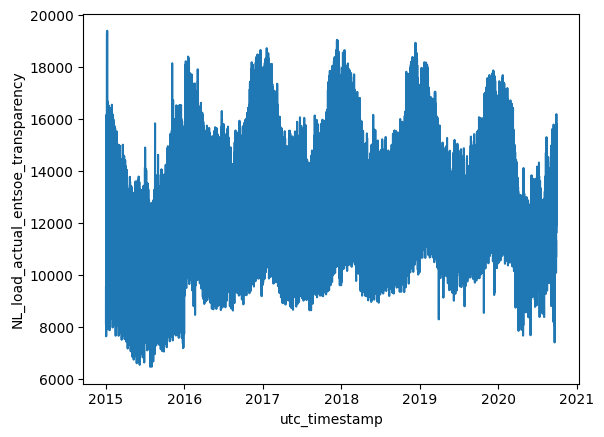

In [43]:
import seaborn as sns

sns.lineplot(data = df, x ='utc_timestamp', y= 'NL_load_actual_entsoe_transparency')

**Observations**:
- yearly fluctuations because of the season -> in winter higher electricity demand due to more lighting, heating, more indoor activity



Now we can zoom into a multiple week period

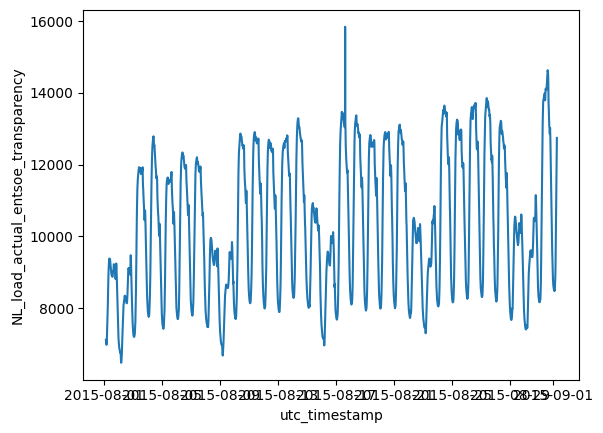

In [44]:
df_multiweek = df.loc["2015-08-01 03:00":"2015-09-01 06:00"]

sns.lineplot(data = df_multiweek, x ='utc_timestamp', y= 'NL_load_actual_entsoe_transparency');

**Observations**
- We can clearly identify the weekdays with a higher demand for electricity, probably due to industry, offices etc.
